# MNIST Classification with PyTorch
 use the [PyTorch](https://pytorch.org/) deep learning framework to create and train a simple deep learning model for handwritten digit classification.

# Enable GPU acceleration

In [ ]:
# make sure to enable GPU acceleration!
device = 'cpu'

# Import packages

Find the PyTorch docs at https://pytorch.org/docs/stable/index.html 

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Set random seed for reproducability
torch.manual_seed(271828)
np.random.seed(271728)

# Specify a model architecture

We will use a simple CNN with two conv layers, one pooling layer, two fully connected, and some dropout.

![Model Architecture](http://www.eeng.dcu.ie/~mcguinne/media/cnn.png)

In [ ]:
class SimpleCNN(nn.Module):

    def __init__(self, num_channels=1, num_classes=10):
        super(SimpleCNN, self).__init__()

        # create the first convolution layer (bottom of the diagram)
        self.conv1 = nn.Conv2d(num_channels, 32, 3, stride=1, padding=1)

        # create the second convolution layer
        self.conv2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        # create the 2x2 max pooling layer
        self.pool1 = nn.MaxPool2d(2)

        # create the dropout operation with p = 0.25
        self.drop1 = nn.Dropout(0.25)

        # create a fully connected layer mapping the output of the pooling layer to 128 dimensions
        self.fc1 = nn.Linear(14*14*32, 128)

        # create the second dropout operation with p = 0.5
        self.drop2 = nn.Dropout(0.5)

        # create the final fully connected layer mapping 128 dimensions to 10 classes
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, X):

        # apply conv1 and a relu
        X = F.relu(self.conv1(X))

        # apply conv2 and a relu
        X = F.relu(self.conv2(X))

        # apply the pooling layer and dropout with p=0.25
        X = self.pool1(X)
        X = self.drop1(X)

        # flatten the spatial extents
        X = X.reshape(-1, 14*14*32)

        # apply the first fully connected layer and a relu
        X = F.relu(self.fc1(X))

        # apply dropout with p = 0.5
        X = self.drop2(X)

        # apply the final fully connected layer
        X = self.fc2(X)

        # return the logits (pre-softmax activations)
        return X  

# Load the datasets
specify a **transform** here to convert images to torch tensors.

I'm adding a **normalization** transform here too so that the images have mean zero and unit variance. This is optional. For some problems (models/datasets) proper normalization is important for performance. For others (e.g. models with batch normalization early on), the importance of normalization is less.

PyTorch comes with a built-in dataset class for the MNIST digit classification task in the (optional) ``torchvision`` package. It also has built-in for other common datasets and tasks like CIFAR-10 and ImageNet. See: https://pytorch.org/docs/stable/torchvision/datasets.html


In [ ]:
# transform for the training data
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])

# use the same transform for the validation data
valid_transform = train_transform

# load datasets, downloading if needed
train_set = MNIST('./data/mnist', train=True, download=True, 
                  transform=train_transform)
valid_set = MNIST('./data/mnist', train=False, download=True, 
                  transform=valid_transform)

In [ ]:
print(f'train set is', ' x '.join(str(x) for x in train_set.data.shape))
print(f'valid set is', ' x '.join(str(x) for x in valid_set.data.shape))

train set is 60000 x 28 x 28
valid set is 10000 x 28 x 28


## Some notes about the training data

There are two subsets of the data being used here:

- **Training data** Data that is used to optimize model parameters
- **Validation data** Data that is used for model selection (choosing hyperparameters).

The data that we test on during training to monitor progress is validation data, since it can be used to tune the model architecture (number of layers, etc) and other hyperparameters.

Usually, we would keep another separate **test set** for testing the final model in order to get an unbiased estimate of *out of sample* accuracy. Unfortunately, MNIST doesn't have a separate test set and it is common practice on this task to use the validation set both for validation and test. 

**Warning**: This is considered BAD PRACTICE in most situations!


# Preview the data

Let's look at a sample of the training data. 

Here we'll use some indexing tricks (reshaping and permuting axes) to put the first 64 digits in the dataset into a grid.

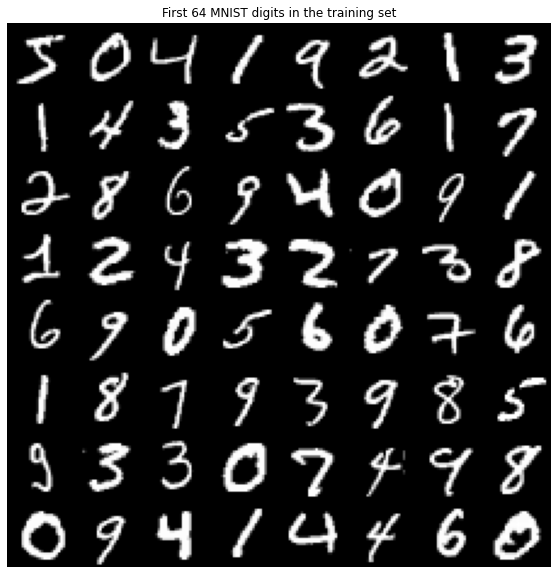

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0]


In [ ]:
# grab the first 64 samples from the training set
sample = train_set.data[:64]

# sample shape is (64, 28, 28), but we would like a grid of 8x8 images, each of size 28x28.
# this would mean an image with width and height of 8*28. How do we go from a (64, 28, 28)
# image to one of size (8*27, 8*28)?

# start by splitting the first dimension (64) int 8 x 8
sample = sample.reshape(8, 8, 28, 28)

# the shape is now (8, 8, 28, 28). Next, move the second dimension to the third position
sample = sample.permute(0, 2, 1, 3)

# the shape is now (8, 28, 8, 28). Finally, collapse the first-second and third-forth
# dimensions into one.
sample = sample.reshape(8*28, 8*28)

# Voila! the shape is (8*28, 8*28). Note that we can't just reshape to this shape immediately,
# because the dimension permute in step two above is also needed.

# Show the images
plt.figure(figsize=(10,10))
plt.imshow(sample)
plt.axis('off')
plt.title('First 64 MNIST digits in the training set')
plt.gray()
plt.show()

print('Labels:', train_set.targets[:64].numpy())

# Setup the data loaders

PyTorch provides a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class in `torch.utils.data` that can be used to manage loading data from datasets using multiple worker threads and packaging data into datasets. It also provides data **shuffling** and **sampling** strategies.

Having multiple threads to load the data improve the performance when training larger models on large datasets since the CPU threads can be busy loading and transforming data while the GPU is doing forward and backward propagation.


**Note**: The `Dataset` and `DataLoader` classes are not mandatory in PyTorch; you can write your own data loading mechanisms. 

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, num_workers=0, shuffle=True)

# create a similar data loader for the validation set, but turn off shuffle and make 
# the batch size 512
valid_loader = DataLoader(valid_set, batch_size=512, num_workers=0, shuffle=False)

# Instantiate the model

Create an instance of the model and move it (memory and operations) to the CUDA device.

In [ ]:
model = SimpleCNN()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Let's count the total number of parameters in our model.

In [ ]:
def count_parameters(model):
    total = 0
    for p in model.parameters():
        
        # compute the total parameters in the layer
        # which is equal to the product of the dimensions
        # in p.shape (np.prod may be helpful)

        layer_count = np.prod(p.shape)

        total += layer_count
    return total


print(f'The model has {count_parameters(model)} parameters')

The model has 813802 parameters


# Train the model

We're almost ready to train the model!

Each pass through the training loop is called an *epoch* (an epoch is when every training example has been seen once). 

It's a good idea to save a snapshot (or *checkpoint*) of the model and the optimizer after every epoch. Let's setup some helpers to do this

In [ ]:
# we will save checkpoints to the checkpoints folder. Create it.
!mkdir -p checkpoints

In [ ]:
def save_checkpoint(optimizer, model, epoch, filename):
    checkpoint_dict = {
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(optimizer, model, filename):
    checkpoint_dict = torch.load(filename)
    epoch = checkpoint_dict['epoch']
    model.load_state_dict(checkpoint_dict['model'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    return epoch

Let's code up the training loop as a function. There are two parts to the loop:
- **Train phase**: where batches of data are loaded from the training set and the model parameters are optimized using backpropagation to compute gradients.
- **Validation phase**: where batches of data are loaded from the validation set and out of sample error is estimated using this data.

In [ ]:
# create the criterion to optimize (the loss function). This is a multi-class classification 
# problem, so categorical cross entropy is an appropriate loss.
criterion = nn.CrossEntropyLoss()

# create an SGD optimizer with learning rate 0.01, momentum 0.9, and nesterov momentum turned on
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)


def train_for_epoch():

    # put model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_loader:
        # Move the training data to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = criterion(predictions, targets)

        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update average loss
        train_losses.append(loss.item())

    # calculate average training loss
    train_loss = np.mean(train_losses)

    return train_loss


def validate():

    # put model in evaluation mode
    model.eval()

    # keep track of losses and predictions
    valid_losses = []
    y_pred = []

    # We don't need gradients for validation, so wrap in 
    # no_grad to save memory
    with torch.no_grad():

        for batch, targets in valid_loader:

            # Move the training batch to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # forward propagation
            predictions = model(batch)

            # calculate the loss
            loss = criterion(predictions, targets)

            # update running loss value
            valid_losses.append(loss.item())

            # save predictions
            y_pred.extend(predictions.argmax(dim=1).cpu().numpy())

    # compute the average validation loss
    valid_loss = np.mean(valid_losses)

    # Collect predictions into y_pred and ground truth into y_true
    y_pred = np.array(y_pred, dtype=np.float32)
    y_true = np.array(valid_set.targets, dtype=np.float32)

    # Calculate accuracy as the average number of times y_true == y_pred
    #accuracy = np.array(np.where(y_true==y_pred)).size/y_true.size
    #counter = np.zeros(len(y_true))
    counter = 0
    for i in range(len(y_true)):
        if(y_pred[i]==y_true[i]):
            counter += 1
    accuracy = counter/len(y_true) 
    
    return valid_loss, accuracy


def train(first_epoch, num_epochs):
    
    train_losses, valid_losses = [],  []

    for epoch in range(first_epoch, first_epoch + num_epochs):

        # training phase
        train_loss = train_for_epoch()

        # validarion phase
        valid_loss, valid_acc = validate()        

        print(f'[{epoch:03d}] train loss: {train_loss:04f}  '
              f'val loss: {valid_loss:04f}  '
              f'val acc: {valid_acc*100:.4f}%')
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # Save a checkpoint
        checkpoint_filename = f'checkpoints/mnist-{epoch:03d}.pkl'
        save_checkpoint(optimizer, model, epoch, checkpoint_filename)
    
    return train_losses, valid_losses

Train the model for 10 epochs

In [ ]:
train_losses, valid_losses = train(1, 10)

[001] train loss: 0.520342  val loss: 0.165529  val acc: 95.2900%
[002] train loss: 0.231702  val loss: 0.097414  val acc: 96.9700%
[003] train loss: 0.150509  val loss: 0.062125  val acc: 98.0600%
[004] train loss: 0.113315  val loss: 0.055045  val acc: 98.1800%
[005] train loss: 0.094428  val loss: 0.044978  val acc: 98.5200%
[006] train loss: 0.080537  val loss: 0.039863  val acc: 98.7100%
[007] train loss: 0.073856  val loss: 0.038524  val acc: 98.6400%
[008] train loss: 0.065325  val loss: 0.035860  val acc: 98.7600%
[009] train loss: 0.059858  val loss: 0.034816  val acc: 98.8400%
[010] train loss: 0.055952  val loss: 0.032375  val acc: 98.8900%


# Plot the learning curves

Here we plot the learning curves after training. Note that you can also use [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) with PyTorch in Google Colab. We'll see how to do this in a future lab


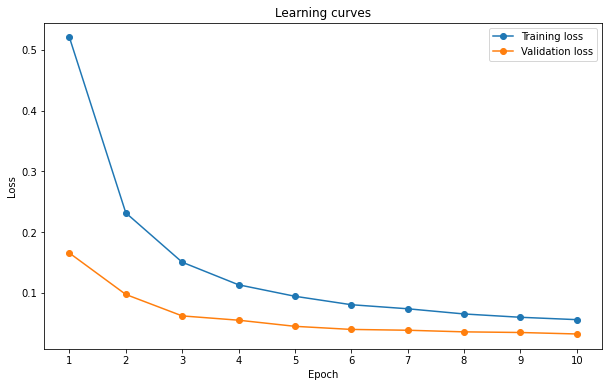

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

# Error analysis

Here we will take a look at the validation samples that the model got wrong. This is often a good idea when trying to improve a models, since it gives you some intuition about the kinds of examples the model finds difficult, which can lead to insights on how to improve models.

We start by defining a predict function which takes a data loader and produces predictions for all samples. The predictions here are a categorical distribution over the 10 different digits, which means that each prediction has dimension 10. We can recover the label for which the model is most confident by taking an $\arg\max$ over the predicted distribution.

In [ ]:
def predict(data_loader):
    model.eval()

    # save the predictions in this list
    y_pred = []

    # no gradient needed
    with torch.no_grad():

        # go over each batch in the loader. We can ignore the targets here
        for batch, _ in data_loader:

            # Move batch to the GPU
            batch = batch.to(device)

            # predict probabilities of each class
            predictions = model(batch)

            # apply a softmax to the predictions
            predictions = F.softmax(predictions, dim=1)
            
            # move to the cpu and convert to numpy
            predictions = predictions.cpu().numpy()

            # save
            y_pred.append(predictions)
    
    # stack predictions into a (num_samples, 10) array
    y_pred = np.vstack(y_pred)
    return y_pred


In [ ]:
# compute predictions on the validation set
y_pred = predict(valid_loader)

# find the argmax of each of the predictions
y_pred = y_pred.argmax(axis=1)

# get the true labels and convert to numpy
y_true = np.array(valid_set.targets)

In [ ]:
# calculate the number of errors
num_errors = np.sum(y_true != y_pred)
print(f'Validation errors {num_errors} (out of {len(valid_set)})')

Validation errors 111 (out of 10000)


Find examples of mistakes in the valid set

In [ ]:
error_indicator = y_pred != y_true
error_examples = valid_set.data[error_indicator, :, :]
print(error_examples.shape)

torch.Size([111, 28, 28])


Show 64 of the mistakes the model has made

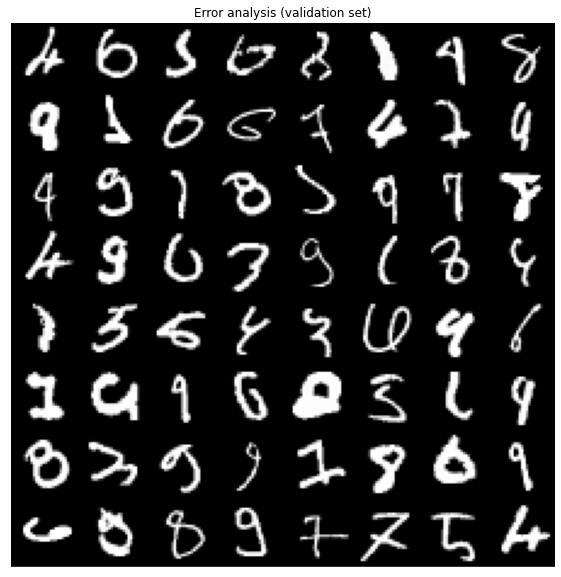

y_true: [4 6 5 6 8 1 4 8 8 1 6 6 7 4 7 9 4 9 7 8 5 9 7 8 4 9 0 3 9 1 8 9 1 5 5 4 3
 6 4 6 1 9 9 6 2 5 6 9 8 3 9 9 1 8 6 9 6 5 8 9 7 7 5 4]
y_pred: [2 0 3 0 2 8 9 7 9 2 0 5 2 6 2 4 9 5 1 0 3 4 9 7 6 3 6 7 5 6 3 4 7 3 6 8 7
 0 9 1 2 0 1 5 0 3 1 4 0 2 7 7 2 9 0 1 4 0 0 3 2 2 0 6]


In [ ]:
plt.figure(figsize=(10,10))

sample = error_examples[:64]
# shape (64, 28, 28)
sample = sample.reshape(8, 8, 28, 28)
# shape (8, 8, 28, 28)
sample = sample.permute(0, 2, 1, 3)
# shape (8, 28, 8, 28)
sample = sample.reshape(8*28, 8*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Error analysis (validation set)')
plt.show()

print('y_true:', y_true[error_indicator][:64])
print('y_pred:', y_pred[error_indicator][:64])

# Resuming training

Let's load up the final model and resume training to see how far we can push up the accuracy.

In [ ]:
ls checkpoints

mnist-001.pkl  mnist-003.pkl  mnist-005.pkl  mnist-007.pkl  mnist-009.pkl
mnist-002.pkl  mnist-004.pkl  mnist-006.pkl  mnist-008.pkl  mnist-010.pkl


In [ ]:
# Load the checkpoint corresponding to the 10th epoch
epoch = load_checkpoint(optimizer,model,'checkpoints/mnist-010.pkl')
print('Resuming training from epoch', epoch)

# train for 10 more epochs
train_losses, valid_losses = train(epoch+1, 10)


Resuming training from epoch 10
[011] train loss: 0.051242  val loss: 0.032460  val acc: 98.9700%
[012] train loss: 0.049361  val loss: 0.030237  val acc: 98.9400%
[013] train loss: 0.047458  val loss: 0.033687  val acc: 98.9700%
[014] train loss: 0.045066  val loss: 0.032378  val acc: 98.9700%
[015] train loss: 0.040632  val loss: 0.029316  val acc: 99.0500%
[016] train loss: 0.041168  val loss: 0.029066  val acc: 99.0500%
[017] train loss: 0.037899  val loss: 0.029941  val acc: 99.0800%
[018] train loss: 0.036157  val loss: 0.030013  val acc: 99.0600%
[019] train loss: 0.033592  val loss: 0.028094  val acc: 99.0700%
[020] train loss: 0.032364  val loss: 0.028967  val acc: 99.0800%


Plot the learning curves

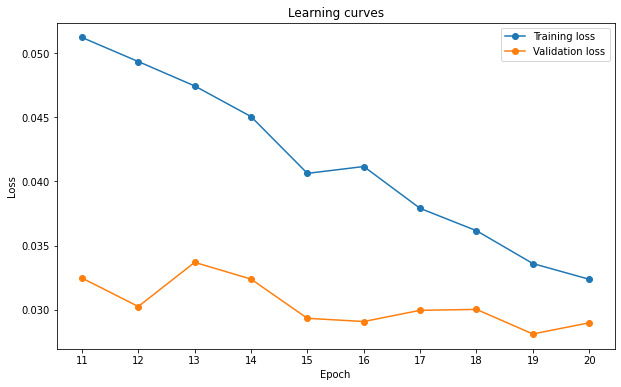

In [ ]:
# plot the learning curves
epochs = range(epoch+1, len(train_losses) + epoch + 1)

# see previous code for how to do this
plt.figure(figsize=(10,6))
plt.plot(epochs, train_losses, '-o', label='Training loss')
plt.plot(epochs, valid_losses, '-o', label='Validation loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

Finally, load the model with the minimum validation error and do an error analysis (show the examples it gets wrong)

> Indented block



In [ ]:
epoch_num = np.argmin(valid_losses)
epoch_num = epoch_num + 11

checkpoint_filename = f'checkpoints/mnist-{epoch_num:03d}.pkl'

epoch = load_checkpoint(optimizer,model,checkpoint_filename)
print('selected epoch', epoch)

NameError: ignored

In [ ]:
# compute predictions on the validation set
y_pred = predict(valid_loader)

# find the argmax of each of the predictions
y_pred = y_pred.argmax(axis=1)

# get the true labels and convert to numpy
y_true = np.array(valid_set.targets)

In [ ]:
# calculate the number of errors
num_errors = np.sum(y_true != y_pred)
print(f'Validation errors {num_errors} (out of {len(valid_set)})')

Validation errors 92 (out of 10000)


In [ ]:
error_indicator = y_pred != y_true
error_examples = valid_set.data[error_indicator, :, :]
print(error_examples.shape)

torch.Size([92, 28, 28])


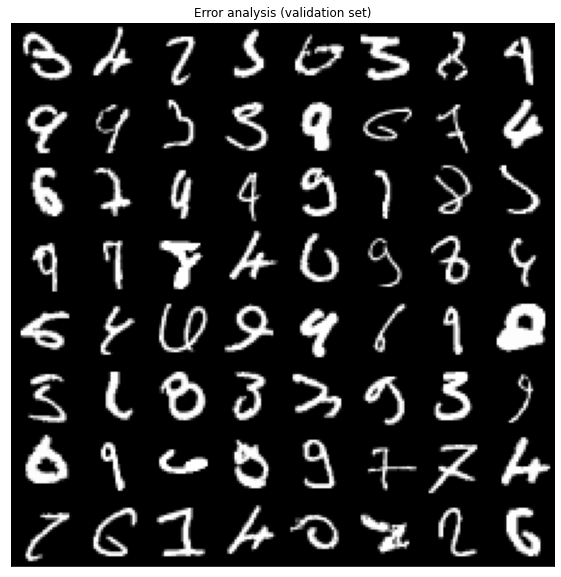

y_true: [3 4 2 5 6 3 8 4 9 9 3 3 8 6 7 4 6 7 9 4 9 7 8 5 9 7 8 4 0 9 8 9 5 4 6 9 4
 6 9 2 5 6 8 3 3 9 3 9 6 9 6 5 9 7 7 4 7 6 1 4 0 2 2 6]
y_pred: [5 2 7 3 0 5 2 9 8 7 5 5 9 5 3 6 5 2 4 9 5 1 2 3 7 9 7 6 6 5 3 4 6 8 0 8 9
 1 1 0 3 1 0 2 2 5 5 7 0 1 4 0 3 2 2 6 8 8 3 6 2 7 1 5]


In [ ]:
plt.figure(figsize=(10,10))

sample = error_examples[:64]
# shape (64, 28, 28)
sample = sample.reshape(8, 8, 28, 28)
# shape (8, 8, 28, 28)
sample = sample.permute(0, 2, 1, 3)
# shape (8, 28, 8, 28)
sample = sample.reshape(8*28, 8*28)
# shape (8*28, 8*28)
plt.imshow(sample)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Error analysis (validation set)')
plt.show()

print('y_true:', y_true[error_indicator][:64])
print('y_pred:', y_pred[error_indicator][:64])